# 🐔 Étude de marché

Une entreprise française d'agroalimentaire spécialisée dans le poulet souhaite se développer à l'international. Sa stratégie mise sur l'exportation, préférable dans un premier temps à une production sur place. Il faudra donc cibler les pays les plus enclins à importer du poulet.

Pour identifier ce groupe de pays, on pourra étudier leurs indicateurs de démographies et régimes alimentaires grâce aux données mises à disposition par la [FAO](http://www.fao.org/home/fr/).


## Sommaire

- [Préparation des données](#Préparation-des-données)
    - [Check de doublons et de valeurs manquantes](#Check-de-doublons-et-de-valeurs-manquantes)
    - [Disponibilité alimentaire](#Disponibilité-alimentaire)
    - [Population](#Population)
    - [PIB](#PIB)
    - [Indice de sécurité](#Indice-de-sécurité)
    - [Disponobilité de poulets](#Disponobilité-de-poulets)
    - [Analyse bi variée](#Analyse-bi-variée)
- [Clustering CAH](#Clustering-CAH)
    - [Normalisation des variables](#Normalisation-des-variables)
    - [CAH affichage du Dendogram global](#CAH-affichage-du-Dendogram-global)


In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn as sk
import scipy as sp
import pca as pca
import pandas as pd
import seaborn as sns
from scipy.cluster.hierarchy import linkage, fcluster, dendrogram
from sklearn import preprocessing
from sklearn import cluster, metrics
from sklearn import decomposition

## Préparation des données

Quatre jeux de données issus de la page FAO. 

In [5]:
#Import des fichiers csv extraits  du site de la FAO
alim = pd.read_csv('dispo-alim.csv')
poulet = pd.read_csv('dispo-poulet.csv')
population = pd.read_csv('population.csv')
securite = pd.read_csv('pib.csv')

#### Check de doublons et de valeurs manquantes

In [6]:
#Recherche de doublon
print('doublon alim : ' + str(alim.duplicated().sum()))
print('doublon poulet : ' + str(poulet.duplicated().sum()))
print('doublon population : ' + str(population.duplicated().sum()))
print('doublon securite : ' + str(securite.duplicated().sum()))

doublon alim : 0
doublon poulet : 0
doublon population : 0
doublon securite : 0


In [7]:
#Recherche de valeurs manquantes 
print('Valeurs manquantes alim : ' + str(alim.isna().any().sum()))
print('Valeurs manquantes poulet : ' + str(poulet.isna().any().sum()))
print('Valeurs manquantes population : ' + str(population.isna().any().sum()))
print('Valeurs manquantes securite : ' + str(securite.duplicated().isna().any().sum()))

Valeurs manquantes alim : 0
Valeurs manquantes poulet : 0
Valeurs manquantes population : 1
Valeurs manquantes securite : 0


In [8]:
#check de la valeur manquante de population.csv
population.isna().any()

Domain Code         False
Domain              False
Area Code (FAO)     False
Area                False
Element Code        False
Element             False
Item Code           False
Item                False
Year Code           False
Year                False
Unit                False
Value               False
Flag                False
Flag Description    False
Note                 True
dtype: bool

La variable note n'est pas importante

On va construire une Dataframe qui contient la liste des pays et les indicateurs qu'on va utiliser pour ananlyser le marcher cible
Les indicateurs choisis sont les suivants:   
  
    
    
-  __Food supply (kcal/capita/day)__ : Disponibilité alimentaire  
-  __%animale/totales__ : Ratio de preteines animale sur proteines total  
-  __%Evolution Population__ : Evolution de la population entre 2008 et 2018  
-  __%Evolution PIB__ : Evolution du PIB entre 2008 et 2018  
-  __Secu__ : indice de stabilité et sécurité  
-  __impdisp__	: Ratio imports poulets sur disponibilité total (= production + imports - exports)  
-  __proddisp__ : Ratio production poulets sur disponibilité total

In [9]:
#suppression des champs non utilisés
alim=alim.drop(['Domain', 'Area Code (FAO)'], axis=1) 
poulet = poulet.drop(['Domain', 'Area Code (FAO)'], axis=1) 
population = population.drop(['Domain', 'Area Code (FAO)'], axis=1) 
securite = securite.drop(['Domain', 'Area Code (FAO)'], axis=1)


#### Disponibilité alimentaire

In [10]:
alim.head()

,Domain Code,Area,Element Code,Element,Item Code,Item,Year Code,Year,Unit,Value,Flag,Flag Description
0,FBS,Afghanistan,664,Food supply (kcal/capita/day),2901,Grand Total,2019,2019,kcal/capita/day,2273.00,Fc,Calculated data
1,FBS,Afghanistan,674,Protein supply quantity (g/capita/day),2901,Grand Total,2019,2019,g/capita/day,57.31,Fc,Calculated data
2,FBS,Afghanistan,664,Food supply (kcal/capita/day),2941,Animal Products,2019,2019,kcal/capita/day,187.00,Fc,Calculated data
3,FBS,Afghanistan,674,Protein supply quantity (g/capita/day),2941,Animal Products,2019,2019,g/capita/day,10.34,Fc,Calculated data
4,FBS,Albania,664,Food supply (kcal/capita/day),2901,Grand Total,2019,2019,kcal/capita/day,3338.00,Fc,Calculated data


on effectu un pivot et on isole une dataframe dediée aux proteines d'origine animales pour pouvoir calculer notre indicateur : __%animale/totales__

In [11]:
alim_pays = alim.pivot_table(index=['Area', 'Item'], 
                                            columns='Element', values='Value', aggfunc=sum).reset_index()
alim_pays.head()

Element,Area,Item,Food supply (kcal/capita/day),Protein supply quantity (g/capita/day)
0,Afghanistan,Animal Products,187.0,10.34
1,Afghanistan,Grand Total,2273.0,57.31
2,Albania,Animal Products,1021.0,62.47
3,Albania,Grand Total,3338.0,116.02
4,Algeria,Animal Products,379.0,24.09


In [12]:
alim_pays.shape

(360, 4)

In [13]:
#nouveau dataframe sur l'origine animale 
prot_animal = alim_pays[alim_pays['Item'] == 'Animal Products'].reset_index(drop=True)
del prot_animal['Item']
prot_animal.head()

Element,Area,Food supply (kcal/capita/day),Protein supply quantity (g/capita/day)
0,Afghanistan,187.0,10.34
1,Albania,1021.0,62.47
2,Algeria,379.0,24.09
3,Angola,211.0,15.54
4,Antigua and Barbuda,720.0,51.32


In [14]:
prot_animal.shape

(180, 3)

On cree notre Dataframe en groupant par pays et on ajoutant notre nouvelle variable %animale/totales

In [15]:
df = alim_pays.groupby('Area').sum().reset_index()
df.head()

Element,Area,Food supply (kcal/capita/day),Protein supply quantity (g/capita/day)
0,Afghanistan,2460.0,67.65
1,Albania,4359.0,178.49
2,Algeria,3872.0,114.93
3,Angola,2656.0,67.63
4,Antigua and Barbuda,3205.0,132.12


In [16]:
df.shape

(180, 3)

In [17]:
df['%animale/totales'] = round(prot_animal['Protein supply quantity (g/capita/day)'] / df['Protein supply quantity (g/capita/day)'] *100, 2)
df.head()

Element,Area,Food supply (kcal/capita/day),Protein supply quantity (g/capita/day),%animale/totales
0,Afghanistan,2460.0,67.65,15.28
1,Albania,4359.0,178.49,35.00
2,Algeria,3872.0,114.93,20.96
3,Angola,2656.0,67.63,22.98
4,Antigua and Barbuda,3205.0,132.12,38.84


#### Population

On va calculer l'evolution de population par pays entre 2008 et 2018. Cet indicateur est tres important parcequ'il reflette l'evolution de la taille du marcher potentiel

In [18]:
population.head()

,Domain Code,Area,Element Code,Element,Item Code,Item,Year Code,Year,Unit,Value,Flag,Flag Description,Note
0,OA,Afghanistan,511,Total Population - Both sexes,3010,Population - Est. & Proj.,2008,2008,1000 persons,27722.276,X,International reliable sources,NaN
1,OA,Afghanistan,511,Total Population - Both sexes,3010,Population - Est. & Proj.,2018,2018,1000 persons,37171.921,X,International reliable sources,NaN
2,OA,Albania,511,Total Population - Both sexes,3010,Population - Est. & Proj.,2008,2008,1000 persons,3002.678,X,International reliable sources,NaN
3,OA,Albania,511,Total Population - Both sexes,3010,Population - Est. & Proj.,2018,2018,1000 persons,2882.740,X,International reliable sources,NaN
4,OA,Algeria,511,Total Population - Both sexes,3010,Population - Est. & Proj.,2008,2008,1000 persons,34730.608,X,International reliable sources,NaN


In [19]:
population.drop(['Element', 'Item','Unit', 'Note'], axis=1, inplace=True)

In [20]:
# on filtre cree une table qui contient les valeurs de population des deux annees
population_a = population[population['Year'] == 2008]
del population_a['Year']


population_b = population[population['Year'] == 2018]
del population_b['Year']


In [21]:
population_pays = pd.merge(population_a, population_b, on='Area')
#population_pays.drop(['Code Pays_y'], axis=1, inplace=True)
population_pays

,Domain Code_x,Area,Element Code_x,Item Code_x,Year Code_x,Value_x,Flag_x,Flag Description_x,Domain Code_y,Element Code_y,Item Code_y,Year Code_y,Value_y,Flag_y,Flag Description_y
0,OA,Afghanistan,511,3010,2008,27722.276,X,International reliable sources,OA,511,3010,2018,37171.921,X,International reliable sources
1,OA,Albania,511,3010,2008,3002.678,X,International reliable sources,OA,511,3010,2018,2882.740,X,International reliable sources
2,OA,Algeria,511,3010,2008,34730.608,X,International reliable sources,OA,511,3010,2018,42228.408,X,International reliable sources
3,OA,American Samoa,511,3010,2008,57.492,X,International reliable sources,OA,511,3010,2018,55.465,X,International reliable sources
4,OA,Andorra,511,3010,2008,83.862,X,International reliable sources,OA,511,3010,2018,77.006,X,International reliable sources
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
225,OA,Wallis and Futuna Islands,511,3010,2008,13.578,X,International reliable sources,OA,511,3010,2018,11.661,X,International reliable sources
226,OA,Western Sahara,511,3010,2008,468.633,X,International reliable sources,OA,511,3010,2018,567.402,X,International reliable sources
227,OA,Yemen,511,3010,2008,21892.146,X,International reliable sources,OA,511,3010,2018,28498.683,X,International reliable sources
228,OA,Zambia,511,3010,2008,12848.530,X,International reliable sources,OA,511,3010,2018,17351.708,X,International reliable sources


In [22]:

population_pays.rename(columns={'Value_x': 'Population 2008', 
                                'Value_y': 'Population 2018'}, inplace=True)

In [23]:
# calcul de l'evolution
population_pays['%Evolution Population'] = round(((population_pays['Population 2018'] - population_pays['Population 2008']))\
                                           / population_pays['Population 2018'] *100, 2)
population_pays.head()

,Domain Code_x,Area,Element Code_x,Item Code_x,Year Code_x,Population 2008,Flag_x,Flag Description_x,Domain Code_y,Element Code_y,Item Code_y,Year Code_y,Population 2018,Flag_y,Flag Description_y,%Evolution Population
0,OA,Afghanistan,511,3010,2008,27722.276,X,International reliable sources,OA,511,3010,2018,37171.921,X,International reliable sources,25.42
1,OA,Albania,511,3010,2008,3002.678,X,International reliable sources,OA,511,3010,2018,2882.740,X,International reliable sources,-4.16
2,OA,Algeria,511,3010,2008,34730.608,X,International reliable sources,OA,511,3010,2018,42228.408,X,International reliable sources,17.76
3,OA,American Samoa,511,3010,2008,57.492,X,International reliable sources,OA,511,3010,2018,55.465,X,International reliable sources,-3.65
4,OA,Andorra,511,3010,2008,83.862,X,International reliable sources,OA,511,3010,2018,77.006,X,International reliable sources,-8.90


On ajoute l'indicateur : Evolution Population dans notre Dataframe

In [24]:
df = pd.merge(df, population_pays[['Area', '%Evolution Population']], on='Area')
df.head()

,Area,Food supply (kcal/capita/day),Protein supply quantity (g/capita/day),%animale/totales,%Evolution Population
0,Afghanistan,2460.0,67.65,15.28,25.42
1,Albania,4359.0,178.49,35.00,-4.16
2,Algeria,3872.0,114.93,20.96,17.76
3,Angola,2656.0,67.63,22.98,29.58
4,Antigua and Barbuda,3205.0,132.12,38.84,11.31


In [25]:
df.shape

(179, 5)

#### PIB

In [26]:
securite.head()

,Domain Code,Area,Element Code,Element,Item Code,Item,Year Code,Year,Unit,Value,Flag,Flag Description,Note
0,FS,Afghanistan,6126,Value,22013,"Gross domestic product per capita, PPP, dissem...",2008,2008,I$,1484.10,X,International reliable sources,NaN
1,FS,Afghanistan,6126,Value,22013,"Gross domestic product per capita, PPP, dissem...",2018,2018,I$,2033.80,X,International reliable sources,NaN
2,FS,Afghanistan,6125,Value,21032,Political stability and absence of violence/te...,2008,2008,index,-2.69,X,International reliable sources,NaN
3,FS,Afghanistan,6125,Value,21032,Political stability and absence of violence/te...,2018,2018,index,-2.75,X,International reliable sources,NaN
4,FS,Albania,6126,Value,22013,"Gross domestic product per capita, PPP, dissem...",2008,2008,I$,9912.60,X,International reliable sources,NaN


In [27]:
pib=securite[securite['Item']=='Gross domestic product per capita, PPP, dissemination (constant 2011 international $)'].reset_index(drop=True)


In [28]:
pib.head()

,Domain Code,Area,Element Code,Element,Item Code,Item,Year Code,Year,Unit,Value,Flag,Flag Description,Note
0,FS,Afghanistan,6126,Value,22013,"Gross domestic product per capita, PPP, dissem...",2008,2008,I$,1484.1,X,International reliable sources,NaN
1,FS,Afghanistan,6126,Value,22013,"Gross domestic product per capita, PPP, dissem...",2018,2018,I$,2033.8,X,International reliable sources,NaN
2,FS,Albania,6126,Value,22013,"Gross domestic product per capita, PPP, dissem...",2008,2008,I$,9912.6,X,International reliable sources,NaN
3,FS,Albania,6126,Value,22013,"Gross domestic product per capita, PPP, dissem...",2018,2018,I$,13323.8,X,International reliable sources,NaN
4,FS,Algeria,6126,Value,22013,"Gross domestic product per capita, PPP, dissem...",2008,2008,I$,10796.9,X,International reliable sources,NaN


In [29]:
pib.drop(['Element','Item','Unit','Note'], axis=1, inplace=True)

In [30]:
pib

,Domain Code,Area,Element Code,Item Code,Year Code,Year,Value,Flag,Flag Description
0,FS,Afghanistan,6126,22013,2008,2008,1484.1,X,International reliable sources
1,FS,Afghanistan,6126,22013,2018,2018,2033.8,X,International reliable sources
2,FS,Albania,6126,22013,2008,2008,9912.6,X,International reliable sources
3,FS,Albania,6126,22013,2018,2018,13323.8,X,International reliable sources
4,FS,Algeria,6126,22013,2008,2008,10796.9,X,International reliable sources
...,...,...,...,...,...,...,...,...,...
367,FS,Viet Nam,6126,22013,2018,2018,7585.9,X,International reliable sources
368,FS,Zambia,6126,22013,2008,2008,2747.4,X,International reliable sources
369,FS,Zambia,6126,22013,2018,2018,3521.5,X,International reliable sources
370,FS,Zimbabwe,6126,22013,2008,2008,1880.8,X,International reliable sources


On va calculer l'evolution de PIB entre 2008 et 2018. Cet indicateur reflette l'evolution de la capacité d'achat du marcher potentiel

In [31]:
# on filtre cree une table qui contient les valeurs de PIB des deux annees
pib_a = pib[pib['Year'] == 2008]
del pib_a['Year']


pib_b = pib[pib['Year'] == 2018]
del pib_b['Year']

In [32]:
pib_pays = pd.merge(pib_a, pib_b, on='Area')
#pib_pays.drop(['Code Pays_y'], axis=1, inplace=True)
pib_pays

,Domain Code_x,Area,Element Code_x,Item Code_x,Year Code_x,Value_x,Flag_x,Flag Description_x,Domain Code_y,Element Code_y,Item Code_y,Year Code_y,Value_y,Flag_y,Flag Description_y
0,FS,Afghanistan,6126,22013,2008,1484.1,X,International reliable sources,FS,6126,22013,2018,2033.8,X,International reliable sources
1,FS,Albania,6126,22013,2008,9912.6,X,International reliable sources,FS,6126,22013,2018,13323.8,X,International reliable sources
2,FS,Algeria,6126,22013,2008,10796.9,X,International reliable sources,FS,6126,22013,2018,11642.2,X,International reliable sources
3,FS,Angola,6126,22013,2008,7864.4,X,International reliable sources,FS,6126,22013,2018,6933.5,X,International reliable sources
4,FS,Antigua and Barbuda,6126,22013,2008,23131.6,X,International reliable sources,FS,6126,22013,2018,21030.4,X,International reliable sources
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
180,FS,Uzbekistan,6126,22013,2008,4185.6,X,International reliable sources,FS,6126,22013,2018,6755.5,X,International reliable sources
181,FS,Vanuatu,6126,22013,2008,3112.3,X,International reliable sources,FS,6126,22013,2018,3093.5,X,International reliable sources
182,FS,Viet Nam,6126,22013,2008,4628.0,X,International reliable sources,FS,6126,22013,2018,7585.9,X,International reliable sources
183,FS,Zambia,6126,22013,2008,2747.4,X,International reliable sources,FS,6126,22013,2018,3521.5,X,International reliable sources


In [33]:
pib_pays.rename(columns={'Value_x': 'pib 2008', 
                                'Value_y': 'pib 2018'}, inplace=True)

In [34]:
#Calcul de l'evolution du PIB
pib_pays['%Evolution PIB'] = round(((pib_pays['pib 2018'] - pib_pays['pib 2008']))\
                                           / pib_pays['pib 2008'] *100, 2)
pib_pays.head()

,Domain Code_x,Area,Element Code_x,Item Code_x,Year Code_x,pib 2008,Flag_x,Flag Description_x,Domain Code_y,Element Code_y,Item Code_y,Year Code_y,pib 2018,Flag_y,Flag Description_y,%Evolution PIB
0,FS,Afghanistan,6126,22013,2008,1484.1,X,International reliable sources,FS,6126,22013,2018,2033.8,X,International reliable sources,37.04
1,FS,Albania,6126,22013,2008,9912.6,X,International reliable sources,FS,6126,22013,2018,13323.8,X,International reliable sources,34.41
2,FS,Algeria,6126,22013,2008,10796.9,X,International reliable sources,FS,6126,22013,2018,11642.2,X,International reliable sources,7.83
3,FS,Angola,6126,22013,2008,7864.4,X,International reliable sources,FS,6126,22013,2018,6933.5,X,International reliable sources,-11.84
4,FS,Antigua and Barbuda,6126,22013,2008,23131.6,X,International reliable sources,FS,6126,22013,2018,21030.4,X,International reliable sources,-9.08


On ajoutte l'indicateur dans notre Dataframe : __%Evolution PIB__

In [35]:
df = pd.merge(df, pib_pays[['Area', '%Evolution PIB']], on='Area')
df.head()

,Area,Food supply (kcal/capita/day),Protein supply quantity (g/capita/day),%animale/totales,%Evolution Population,%Evolution PIB
0,Afghanistan,2460.0,67.65,15.28,25.42,37.04
1,Albania,4359.0,178.49,35.00,-4.16,34.41
2,Algeria,3872.0,114.93,20.96,17.76,7.83
3,Angola,2656.0,67.63,22.98,29.58,-11.84
4,Antigua and Barbuda,3205.0,132.12,38.84,11.31,-9.08


In [36]:
df.shape

(169, 6)

#### Indice de sécurité

Cet indice donne une idée sur la stabilité politique/sécurité du Pays : Plus l'indice est grand plus le pays est stable.  
On va prendre la derniere annees disponible dans le site FAO,2018.

In [37]:
secu=securite[securite['Item']=='Political stability and absence of violence/terrorism (index)'].reset_index(drop=True)


In [38]:
secu=secu[secu['Year']==2018]

In [39]:
secu.rename(columns={'Value': 'Secu'
                                }, inplace=True)
secu.head()

,Domain Code,Area,Element Code,Element,Item Code,Item,Year Code,Year,Unit,Secu,Flag,Flag Description,Note
1,FS,Afghanistan,6125,Value,21032,Political stability and absence of violence/te...,2018,2018,index,-2.75,X,International reliable sources,NaN
3,FS,Albania,6125,Value,21032,Political stability and absence of violence/te...,2018,2018,index,0.38,X,International reliable sources,NaN
5,FS,Algeria,6125,Value,21032,Political stability and absence of violence/te...,2018,2018,index,-0.83,X,International reliable sources,NaN
7,FS,American Samoa,6125,Value,21032,Political stability and absence of violence/te...,2018,2018,index,1.20,X,International reliable sources,NaN
9,FS,Andorra,6125,Value,21032,Political stability and absence of violence/te...,2018,2018,index,1.42,X,International reliable sources,NaN


In [40]:
secu.drop(['Element','Item','Unit','Note'], axis=1, inplace=True)

On ajoutte l'indicateur __Secu__ dans notre Dataframe

In [41]:
df = pd.merge(df, secu[['Area', 'Secu']], on='Area')
df.head()

,Area,Food supply (kcal/capita/day),Protein supply quantity (g/capita/day),%animale/totales,%Evolution Population,%Evolution PIB,Secu
0,Afghanistan,2460.0,67.65,15.28,25.42,37.04,-2.75
1,Albania,4359.0,178.49,35.00,-4.16,34.41,0.38
2,Algeria,3872.0,114.93,20.96,17.76,7.83,-0.83
3,Angola,2656.0,67.63,22.98,29.58,-11.84,-0.32
4,Antigua and Barbuda,3205.0,132.12,38.84,11.31,-9.08,0.85


#### Disponobilité de poulets

In [42]:
poulet.head()

,Domain Code,Area,Element Code,Element,Item Code,Item,Year Code,Year,Unit,Value,Flag,Flag Description
0,FBS,Afghanistan,5511,Production,2734,Poultry Meat,2019,2019,1000 tonnes,28,Im,FAO data based on imputation methodology
1,FBS,Afghanistan,5611,Import Quantity,2734,Poultry Meat,2019,2019,1000 tonnes,44,Im,FAO data based on imputation methodology
2,FBS,Afghanistan,5511,Production,2735,"Meat, Other",2019,2019,1000 tonnes,12,Im,FAO data based on imputation methodology
3,FBS,Afghanistan,5611,Import Quantity,2735,"Meat, Other",2019,2019,1000 tonnes,0,Im,FAO data based on imputation methodology
4,FBS,Albania,5511,Production,2734,Poultry Meat,2019,2019,1000 tonnes,12,Im,FAO data based on imputation methodology


On cree une DF qui contient l'import de poulets

In [43]:
imports = poulet[poulet['Element'] == 'Import Quantity'].reset_index(drop=True)

In [44]:
imports = imports[imports['Item'] == 'Poultry Meat'].reset_index(drop=True)

In [45]:

imports.rename(columns={'Value': 'import'}, inplace=True)
imports.head()

,Domain Code,Area,Element Code,Element,Item Code,Item,Year Code,Year,Unit,import,Flag,Flag Description
0,FBS,Afghanistan,5611,Import Quantity,2734,Poultry Meat,2019,2019,1000 tonnes,44,Im,FAO data based on imputation methodology
1,FBS,Albania,5611,Import Quantity,2734,Poultry Meat,2019,2019,1000 tonnes,22,Im,FAO data based on imputation methodology
2,FBS,Algeria,5611,Import Quantity,2734,Poultry Meat,2019,2019,1000 tonnes,0,Im,FAO data based on imputation methodology
3,FBS,Angola,5611,Import Quantity,2734,Poultry Meat,2019,2019,1000 tonnes,278,Im,FAO data based on imputation methodology
4,FBS,Antigua and Barbuda,5611,Import Quantity,2734,Poultry Meat,2019,2019,1000 tonnes,7,Im,FAO data based on imputation methodology


On cree une DF qui contient l'export de poulets

In [46]:
exports = poulet[poulet['Element'] == 'Export Quantity'].reset_index(drop=True)

In [47]:
exports = exports[exports['Item'] == 'Poultry Meat'].reset_index(drop=True)

In [48]:
exports.rename(columns={'Value': 'export'}, inplace=True)
exports.head()

,Domain Code,Area,Element Code,Element,Item Code,Item,Year Code,Year,Unit,export,Flag,Flag Description
0,FBS,Albania,5911,Export Quantity,2734,Poultry Meat,2019,2019,1000 tonnes,0,Im,FAO data based on imputation methodology
1,FBS,Algeria,5911,Export Quantity,2734,Poultry Meat,2019,2019,1000 tonnes,1,Im,FAO data based on imputation methodology
2,FBS,Angola,5911,Export Quantity,2734,Poultry Meat,2019,2019,1000 tonnes,0,Im,FAO data based on imputation methodology
3,FBS,Antigua and Barbuda,5911,Export Quantity,2734,Poultry Meat,2019,2019,1000 tonnes,0,Im,FAO data based on imputation methodology
4,FBS,Argentina,5911,Export Quantity,2734,Poultry Meat,2019,2019,1000 tonnes,234,Im,FAO data based on imputation methodology


On cree une DF qui contient la production de poulets

In [49]:
production = poulet[poulet['Element'] == 'Production'].reset_index(drop=True)

In [50]:
production = production[production['Item'] == 'Poultry Meat'].reset_index(drop=True)

In [51]:
production.rename(columns={'Value': 'production'}, inplace=True)
production.head()

,Domain Code,Area,Element Code,Element,Item Code,Item,Year Code,Year,Unit,production,Flag,Flag Description
0,FBS,Afghanistan,5511,Production,2734,Poultry Meat,2019,2019,1000 tonnes,28,Im,FAO data based on imputation methodology
1,FBS,Albania,5511,Production,2734,Poultry Meat,2019,2019,1000 tonnes,12,Im,FAO data based on imputation methodology
2,FBS,Algeria,5511,Production,2734,Poultry Meat,2019,2019,1000 tonnes,291,Im,FAO data based on imputation methodology
3,FBS,Angola,5511,Production,2734,Poultry Meat,2019,2019,1000 tonnes,49,Im,FAO data based on imputation methodology
4,FBS,Antigua and Barbuda,5511,Production,2734,Poultry Meat,2019,2019,1000 tonnes,0,Im,FAO data based on imputation methodology


On concatene les trois DF pour pouvoir calculer nos indicateurs

In [52]:
imports2 = pd.merge(imports, exports, on='Area')
imports2.head()

,Domain Code_x,Area,Element Code_x,Element_x,Item Code_x,Item_x,Year Code_x,Year_x,Unit_x,import,...,Element Code_y,Element_y,Item Code_y,Item_y,Year Code_y,Year_y,Unit_y,export,Flag_y,Flag Description_y
0,FBS,Albania,5611,Import Quantity,2734,Poultry Meat,2019,2019,1000 tonnes,22,...,5911,Export Quantity,2734,Poultry Meat,2019,2019,1000 tonnes,0,Im,FAO data based on imputation methodology
1,FBS,Algeria,5611,Import Quantity,2734,Poultry Meat,2019,2019,1000 tonnes,0,...,5911,Export Quantity,2734,Poultry Meat,2019,2019,1000 tonnes,1,Im,FAO data based on imputation methodology
2,FBS,Angola,5611,Import Quantity,2734,Poultry Meat,2019,2019,1000 tonnes,278,...,5911,Export Quantity,2734,Poultry Meat,2019,2019,1000 tonnes,0,Im,FAO data based on imputation methodology
3,FBS,Antigua and Barbuda,5611,Import Quantity,2734,Poultry Meat,2019,2019,1000 tonnes,7,...,5911,Export Quantity,2734,Poultry Meat,2019,2019,1000 tonnes,0,Im,FAO data based on imputation methodology
4,FBS,Argentina,5611,Import Quantity,2734,Poultry Meat,2019,2019,1000 tonnes,5,...,5911,Export Quantity,2734,Poultry Meat,2019,2019,1000 tonnes,234,Im,FAO data based on imputation methodology


In [53]:
temmp_dispo = pd.merge(imports2, production, on='Area')

In [54]:
temmp_dispo.head()

,Domain Code_x,Area,Element Code_x,Element_x,Item Code_x,Item_x,Year Code_x,Year_x,Unit_x,import,...,Element Code,Element,Item Code,Item,Year Code,Year,Unit,production,Flag,Flag Description
0,FBS,Albania,5611,Import Quantity,2734,Poultry Meat,2019,2019,1000 tonnes,22,...,5511,Production,2734,Poultry Meat,2019,2019,1000 tonnes,12,Im,FAO data based on imputation methodology
1,FBS,Algeria,5611,Import Quantity,2734,Poultry Meat,2019,2019,1000 tonnes,0,...,5511,Production,2734,Poultry Meat,2019,2019,1000 tonnes,291,Im,FAO data based on imputation methodology
2,FBS,Angola,5611,Import Quantity,2734,Poultry Meat,2019,2019,1000 tonnes,278,...,5511,Production,2734,Poultry Meat,2019,2019,1000 tonnes,49,Im,FAO data based on imputation methodology
3,FBS,Antigua and Barbuda,5611,Import Quantity,2734,Poultry Meat,2019,2019,1000 tonnes,7,...,5511,Production,2734,Poultry Meat,2019,2019,1000 tonnes,0,Im,FAO data based on imputation methodology
4,FBS,Argentina,5611,Import Quantity,2734,Poultry Meat,2019,2019,1000 tonnes,5,...,5511,Production,2734,Poultry Meat,2019,2019,1000 tonnes,2248,Im,FAO data based on imputation methodology


On va construire nos indicateurs :  
- dispo-total = imports + production - exports : Disponibilité total
- impdisp = imports/dispo-total : sensibilité par rappor à l'import : plus cet indice est grands plus le pays depend de l'importation de poulet.  
- proddsip= production/dispo-total:sensibilité par rappor à la production : plus cet indice est grands plus le pays depend de sa production de poulet.


In [55]:
temmp_dispo['dispo-total']=temmp_dispo['import']-temmp_dispo['export']+temmp_dispo['production']
temmp_dispo['impdisp']=temmp_dispo['import']/temmp_dispo['dispo-total']


In [56]:
temmp_dispo['proddisp']=temmp_dispo['production']/temmp_dispo['dispo-total']

In [57]:

temmp_dispo

,Domain Code_x,Area,Element Code_x,Element_x,Item Code_x,Item_x,Year Code_x,Year_x,Unit_x,import,...,Item,Year Code,Year,Unit,production,Flag,Flag Description,dispo-total,impdisp,proddisp
0,FBS,Albania,5611,Import Quantity,2734,Poultry Meat,2019,2019,1000 tonnes,22,...,Poultry Meat,2019,2019,1000 tonnes,12,Im,FAO data based on imputation methodology,34,0.647059,0.352941
1,FBS,Algeria,5611,Import Quantity,2734,Poultry Meat,2019,2019,1000 tonnes,0,...,Poultry Meat,2019,2019,1000 tonnes,291,Im,FAO data based on imputation methodology,290,0.000000,1.003448
2,FBS,Angola,5611,Import Quantity,2734,Poultry Meat,2019,2019,1000 tonnes,278,...,Poultry Meat,2019,2019,1000 tonnes,49,Im,FAO data based on imputation methodology,327,0.850153,0.149847
3,FBS,Antigua and Barbuda,5611,Import Quantity,2734,Poultry Meat,2019,2019,1000 tonnes,7,...,Poultry Meat,2019,2019,1000 tonnes,0,Im,FAO data based on imputation methodology,7,1.000000,0.000000
4,FBS,Argentina,5611,Import Quantity,2734,Poultry Meat,2019,2019,1000 tonnes,5,...,Poultry Meat,2019,2019,1000 tonnes,2248,Im,FAO data based on imputation methodology,2019,0.002476,1.113422
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
132,FBS,Uruguay,5611,Import Quantity,2734,Poultry Meat,2019,2019,1000 tonnes,6,...,Poultry Meat,2019,2019,1000 tonnes,31,Im,FAO data based on imputation methodology,34,0.176471,0.911765
133,FBS,Uzbekistan,5611,Import Quantity,2734,Poultry Meat,2019,2019,1000 tonnes,21,...,Poultry Meat,2019,2019,1000 tonnes,64,Im,FAO data based on imputation methodology,85,0.247059,0.752941
134,FBS,Viet Nam,5611,Import Quantity,2734,Poultry Meat,2019,2019,1000 tonnes,203,...,Poultry Meat,2019,2019,1000 tonnes,1089,Im,FAO data based on imputation methodology,1255,0.161753,0.867729
135,FBS,Zambia,5611,Import Quantity,2734,Poultry Meat,2019,2019,1000 tonnes,23,...,Poultry Meat,2019,2019,1000 tonnes,51,Im,FAO data based on imputation methodology,65,0.353846,0.784615


On ajoutte nos indicateur dans la Dataframe de l'analyse

In [58]:
df = pd.merge(df, temmp_dispo[['Area', 'impdisp','proddisp']], on='Area')
df.head()

,Area,Food supply (kcal/capita/day),Protein supply quantity (g/capita/day),%animale/totales,%Evolution Population,%Evolution PIB,Secu,impdisp,proddisp
0,Albania,4359.0,178.49,35.00,-4.16,34.41,0.38,0.647059,0.352941
1,Algeria,3872.0,114.93,20.96,17.76,7.83,-0.83,0.000000,1.003448
2,Angola,2656.0,67.63,22.98,29.58,-11.84,-0.32,0.850153,0.149847
3,Antigua and Barbuda,3205.0,132.12,38.84,11.31,-9.08,0.85,1.000000,0.000000
4,Argentina,4321.0,174.84,38.83,9.65,-1.49,0.02,0.002476,1.113422


In [59]:
df.shape

(131, 9)

In [60]:
df.drop(['Protein supply quantity (g/capita/day)'], axis=1, inplace=True)

In [61]:
print(df.duplicated().sum())
print(df.isna().sum())

0
Area                             0
Food supply (kcal/capita/day)    0
%animale/totales                 0
%Evolution Population            0
%Evolution PIB                   0
Secu                             0
impdisp                          0
proddisp                         0
dtype: int64


Notre Dataframe est prete. On dispose de 131 pays sans doublons ni valeurs manquantes

### Analyse bi variée

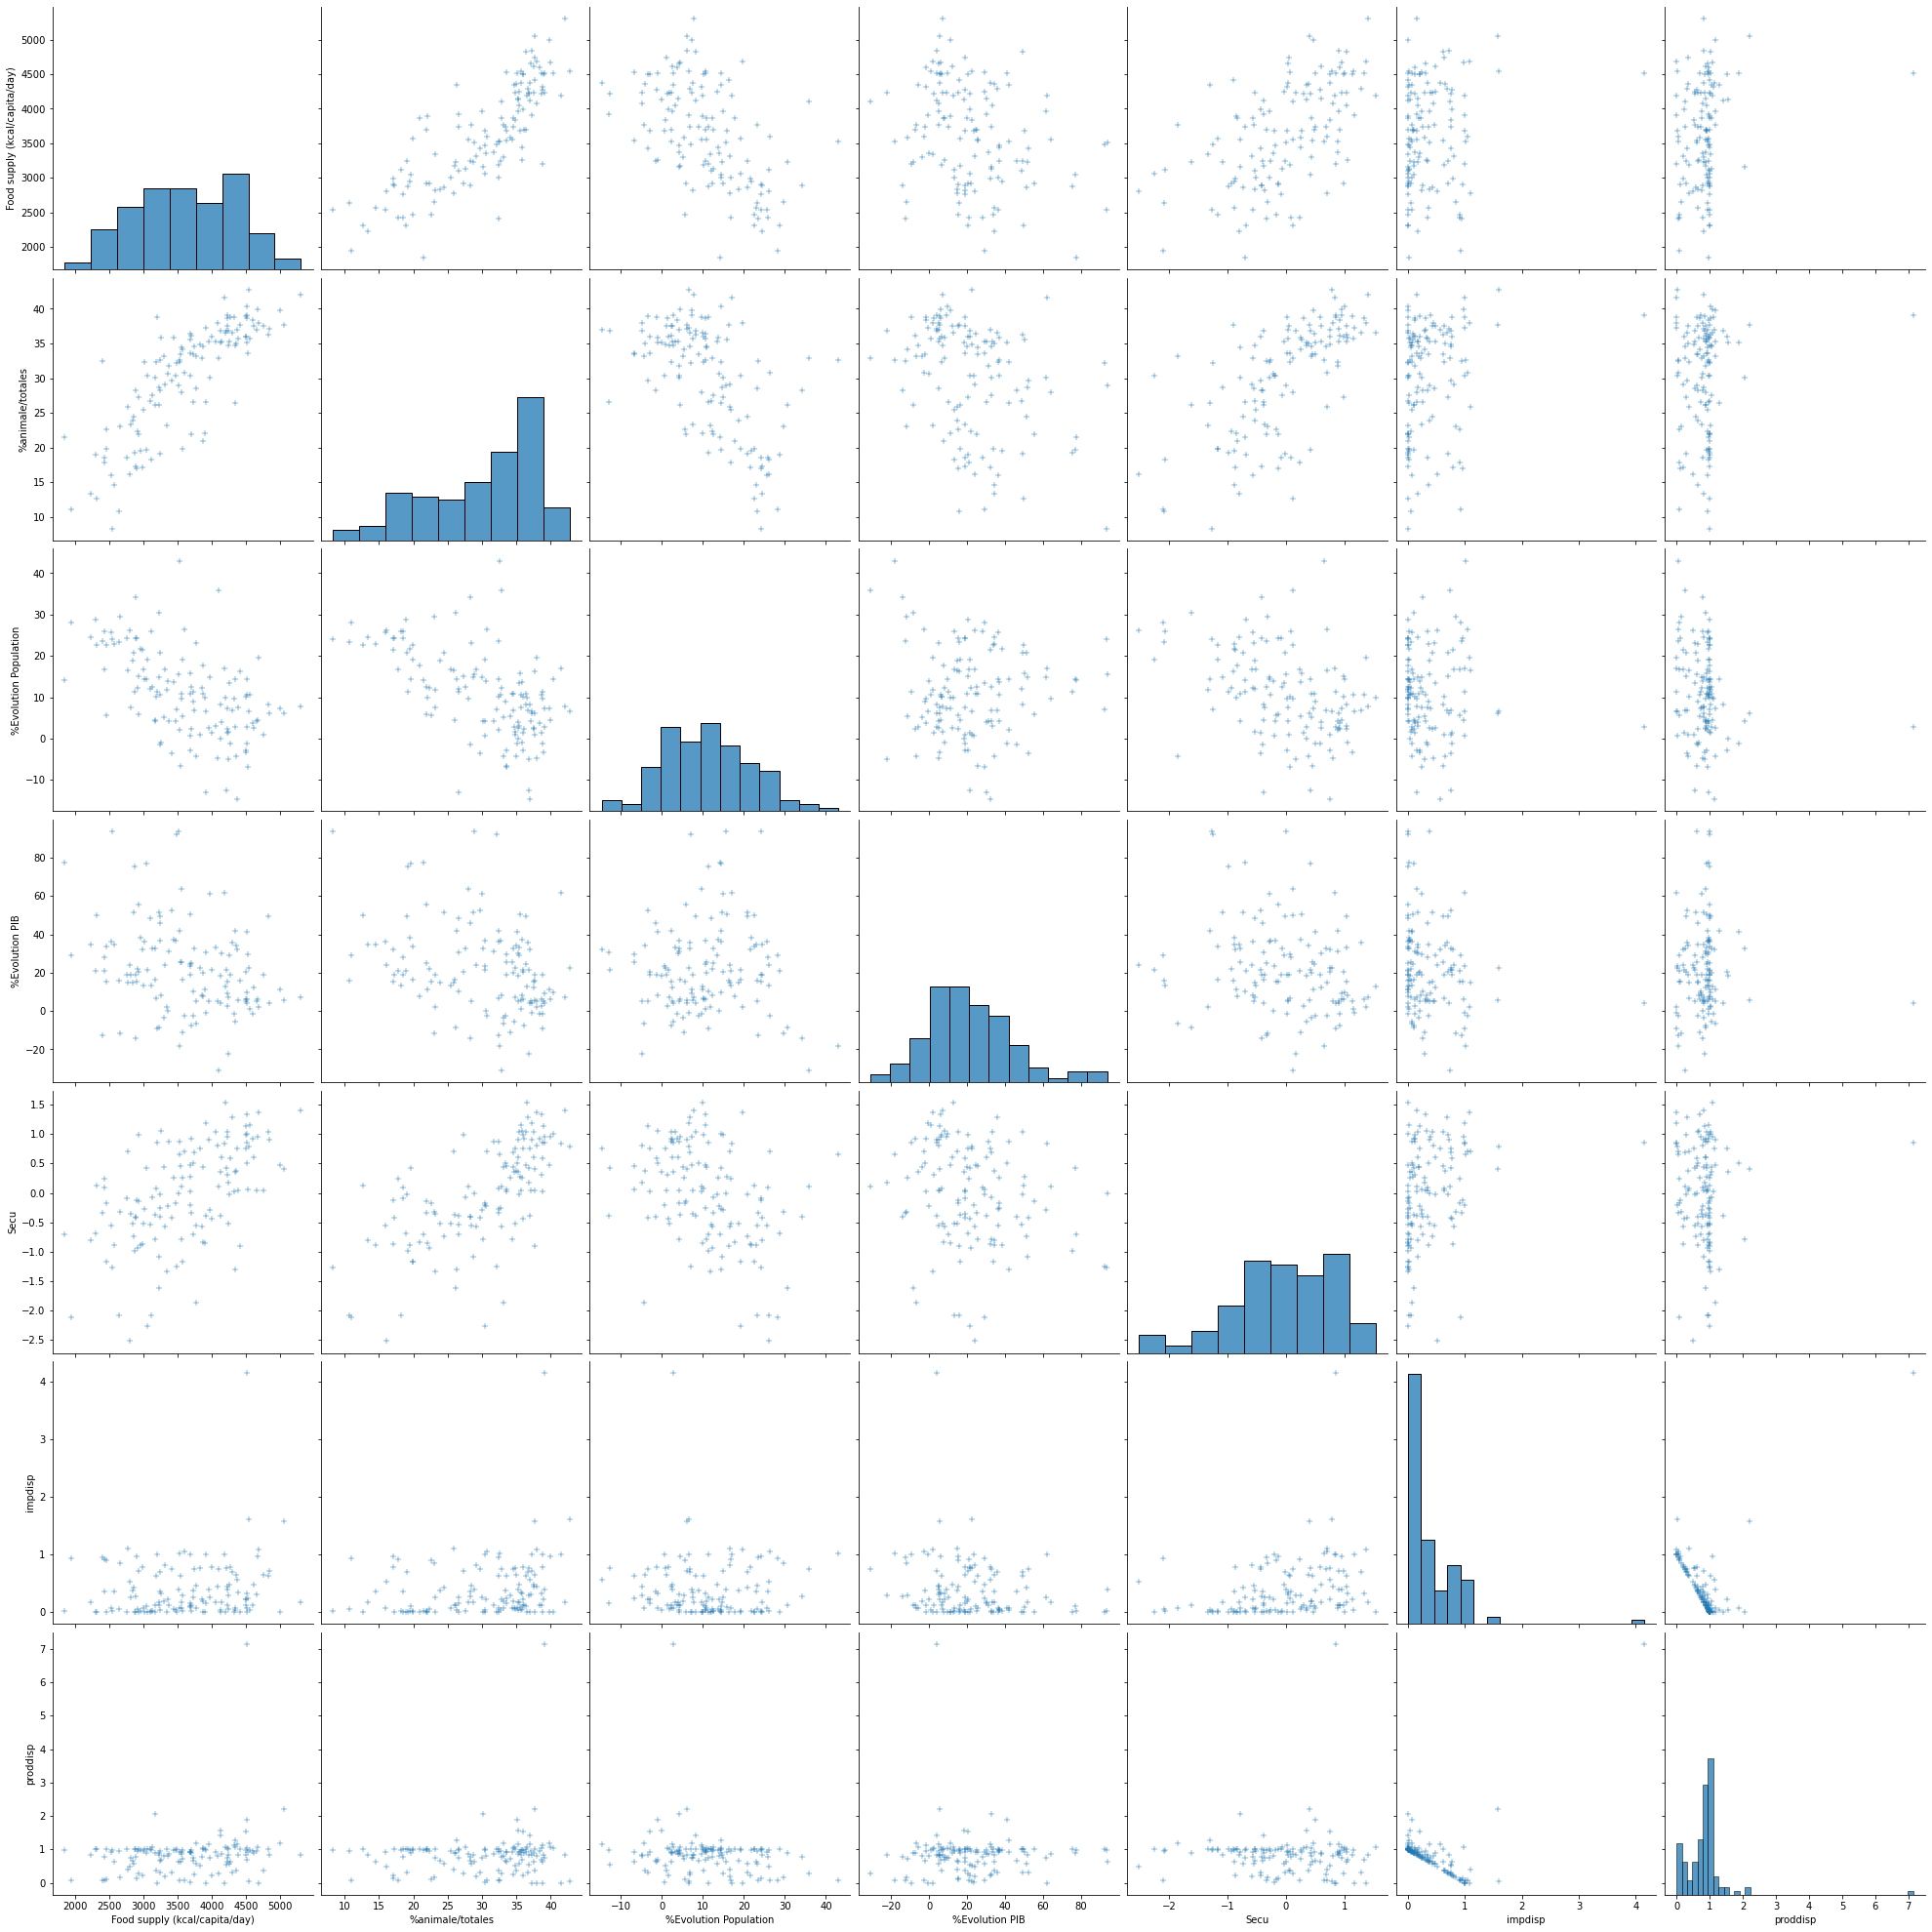

In [62]:
sns.pairplot(df, height=4, markers="+")
plt.show()

corrélation linéaire entre ratio protéines / disponibilité calorique(ce qui est logique). On a également une idée de la distribution de nos variables, avec par exemple une distribution étalée à droite pour le ratio des protéines, ou encore une distribution plutôt symétrique, c'est à dire une distribution normale pour la disponibilité calorique.

Les corelations sont plus visibles dans la matrice de corelcations:

C:\Users\Dell5520\AppData\Local\Temp/ipykernel_14384/4079876423.py:4: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.triu(np.ones_like(matrix, dtype=np.bool))


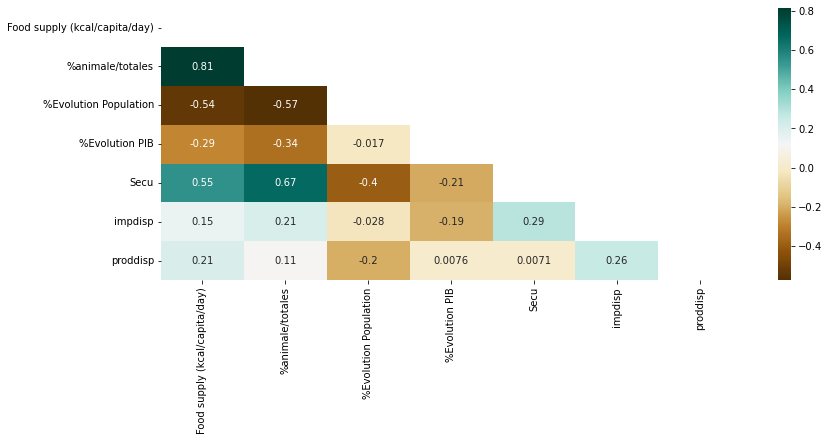

In [63]:
matrix = df.corr()

# Triangle de corrélations
mask = np.triu(np.ones_like(matrix, dtype=np.bool))
plt.figure(figsize=(13, 5))
sns.heatmap(matrix, mask=mask, annot=True, cmap='BrBG')
plt.show()

# Clustering CAH

L'échantillon comporte peu de variables et de nombre de pays ce qui nous permet de commencer par une classification hiérarchique. Algorithme qui a une forte complexité algorithmique en temps et en espace, le clustering hiérarchique est recommandé pour les petits échantillons.

#### Normalisation des variables

L'objectif de la normalisation est de modifier les valeurs des colonnes numériques du jeu de données pour utiliser une échelle commune, sans que les différences de plages de valeurs ne soient faussées et sans perte d'informations.

In [64]:
df.set_index('Area', inplace=True)
X = df.values
X.shape

(131, 7)

In [65]:
std_scale = preprocessing.StandardScaler().fit(X)
X_scaled = std_scale.transform(X)

#### CAH affichage du Dendogram global

In [66]:
Z = linkage(X_scaled, method = 'ward', metric='euclidean')

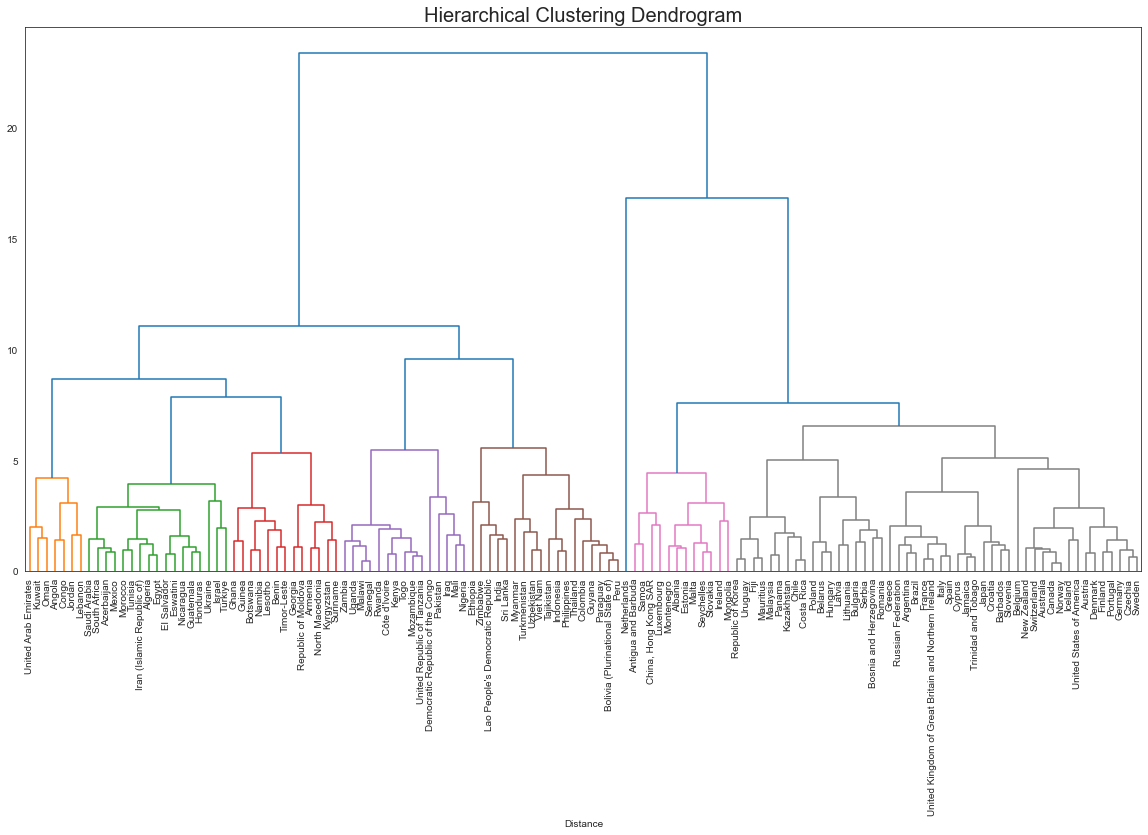

In [67]:
#Affichage d'un premier dendrogramme global
fig =plt.figure(figsize=(20,10))
sns.set_style('white')
plt.title('Hierarchical Clustering Dendrogram', fontsize=20)
plt.xlabel('Distance')

dendrogram(Z, labels = df.index, leaf_font_size=10, color_threshold=7, orientation='top')

plt.show()

On découpe le dendograme en plusieur tailles et essaie de choisr le nombre de groupes adequat

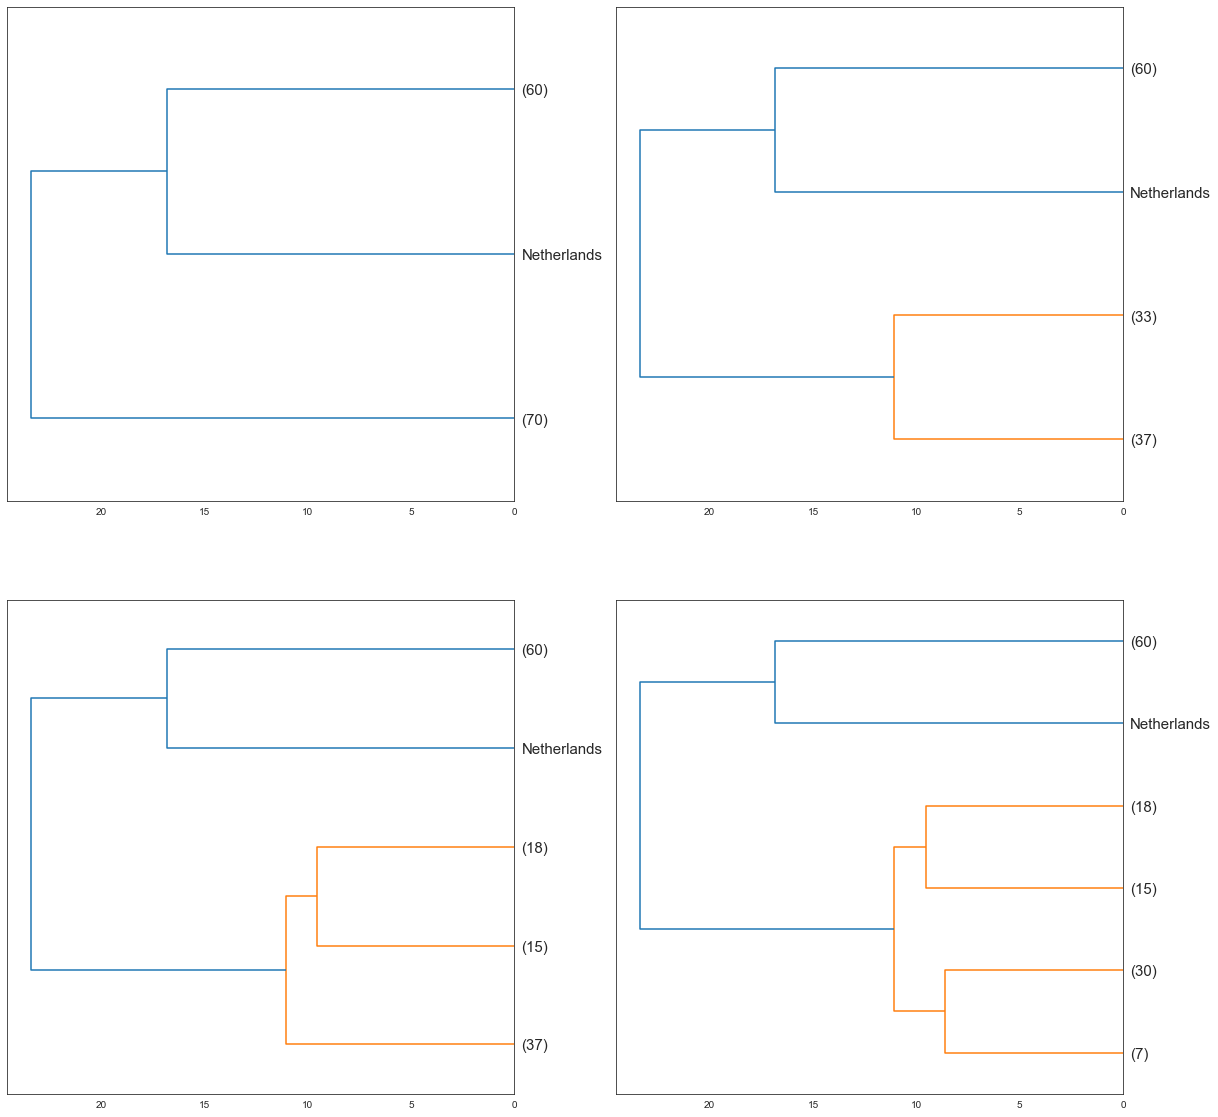

In [68]:


plt.figure(figsize=(20, 20))
dendrogram(Z, labels = df.index, p=2, truncate_mode='lastp', leaf_font_size=15, orientation='left')

plt.subplot(221)
dendrogram(Z, labels = df.index, p=3, truncate_mode='lastp', leaf_font_size=15, orientation='left')

plt.subplot(222)
dendrogram(Z, labels = df.index, p=4, truncate_mode='lastp', leaf_font_size=15, orientation='left')

plt.subplot(223)
dendrogram(Z, labels = df.index, p=5, truncate_mode='lastp', leaf_font_size=15, orientation='left')


plt.subplot(224)
dendrogram(Z, labels = df.index, p=6, truncate_mode='lastp', leaf_font_size=15, orientation='left')

plt.show(block=False)

Le découpage en 5 clusters est le plus equilibré
Les pays bas semble etre un outliers . On va le vérifier manuelement

In [69]:
cah = fcluster(Z, 4, criterion='maxclust')
print(' groupes : ' + str(np.unique(cah)))

#Index trié des groupes
idg = np.argsort(cah)

#Affichage des pays selon leurs groupes
df_groupes_cah = pd.DataFrame(df.index[idg], cah[idg]).reset_index()
df_groupes_cah = df_groupes_cah.rename(columns={'index':'Groupe'})


 groupes : [1 2 3 4]


On Rajoute le résultats de clustering dans notre DF initiale

In [70]:
df_groupes_cah = pd.merge(df, df_groupes_cah, on='Area')

In [71]:
df_groupes_cah_old=df_groupes_cah

In [72]:
df_groupes_cah

,Area,Food supply (kcal/capita/day),%animale/totales,%Evolution Population,%Evolution PIB,Secu,impdisp,proddisp,Groupe
0,Albania,4359.0,35.00,-4.16,34.41,0.38,0.647059,0.352941,3
1,Algeria,3872.0,20.96,17.76,7.83,-0.83,0.000000,1.003448,1
2,Angola,2656.0,22.98,29.58,-11.84,-0.32,0.850153,0.149847,1
3,Antigua and Barbuda,3205.0,38.84,11.31,-9.08,0.85,1.000000,0.000000,3
4,Argentina,4321.0,38.83,9.65,-1.49,0.02,0.002476,1.113422,3
...,...,...,...,...,...,...,...,...,...
126,Uruguay,4052.0,35.35,3.16,33.41,1.04,0.176471,0.911765,3
127,Uzbekistan,3971.0,30.01,14.93,61.40,-0.29,0.247059,0.752941,2
128,Viet Nam,3558.0,28.03,9.74,63.91,0.11,0.161753,0.867729,2
129,Zambia,2429.0,18.51,25.95,28.18,0.09,0.353846,0.784615,2


On determine le cluster des pays bas

In [73]:
df_nether=df_groupes_cah[df_groupes_cah['Area']=='Netherlands']
df_nether

,Area,Food supply (kcal/capita/day),%animale/totales,%Evolution Population,%Evolution PIB,Secu,impdisp,proddisp,Groupe
80,Netherlands,4509.0,39.15,2.88,4.11,0.86,4.151724,7.144828,4


On calcul les moyennes par cluster

In [74]:
cluster_mean = df_groupes_cah.groupby(['Groupe']).mean()
cluster_mean

,Food supply (kcal/capita/day),%animale/totales,%Evolution Population,%Evolution PIB,Secu,impdisp,proddisp
Groupe,,,,,,,
1,3335.189189,26.583784,15.836757,12.608919,-0.428108,0.474553,0.569731
2,2896.272727,22.202727,17.807273,44.271212,-0.763939,0.126385,0.914467
3,4190.850000,36.439333,4.099500,15.409333,0.621167,0.394929,0.842507
4,4509.000000,39.150000,2.880000,4.110000,0.860000,4.151724,7.144828


On déduit que c'est plutos import/production qui ont départagre les pays bas des autres pays ,les moyennes sont largement detaché des autres groupes.
Puisque les pays bas sont déja de grands importateurs et producteur du poulet;aussi vu que l'evolution de la poulation n'est pas interessante
on ne va pas choisir les pays pas.
Pour le reste de l'analyse on va pas en tenir compte

In [75]:
df_groupes_cah.drop(df_groupes_cah.index[df_groupes_cah['Area'] == 'Netherlands'], inplace=True)


In [76]:
df_groupe1_cah = df_groupes_cah[df_groupes_cah['Groupe'] == 1]
df_groupe2_cah = df_groupes_cah[df_groupes_cah['Groupe'] == 2]
df_groupe3_cah = df_groupes_cah[df_groupes_cah['Groupe'] == 3]


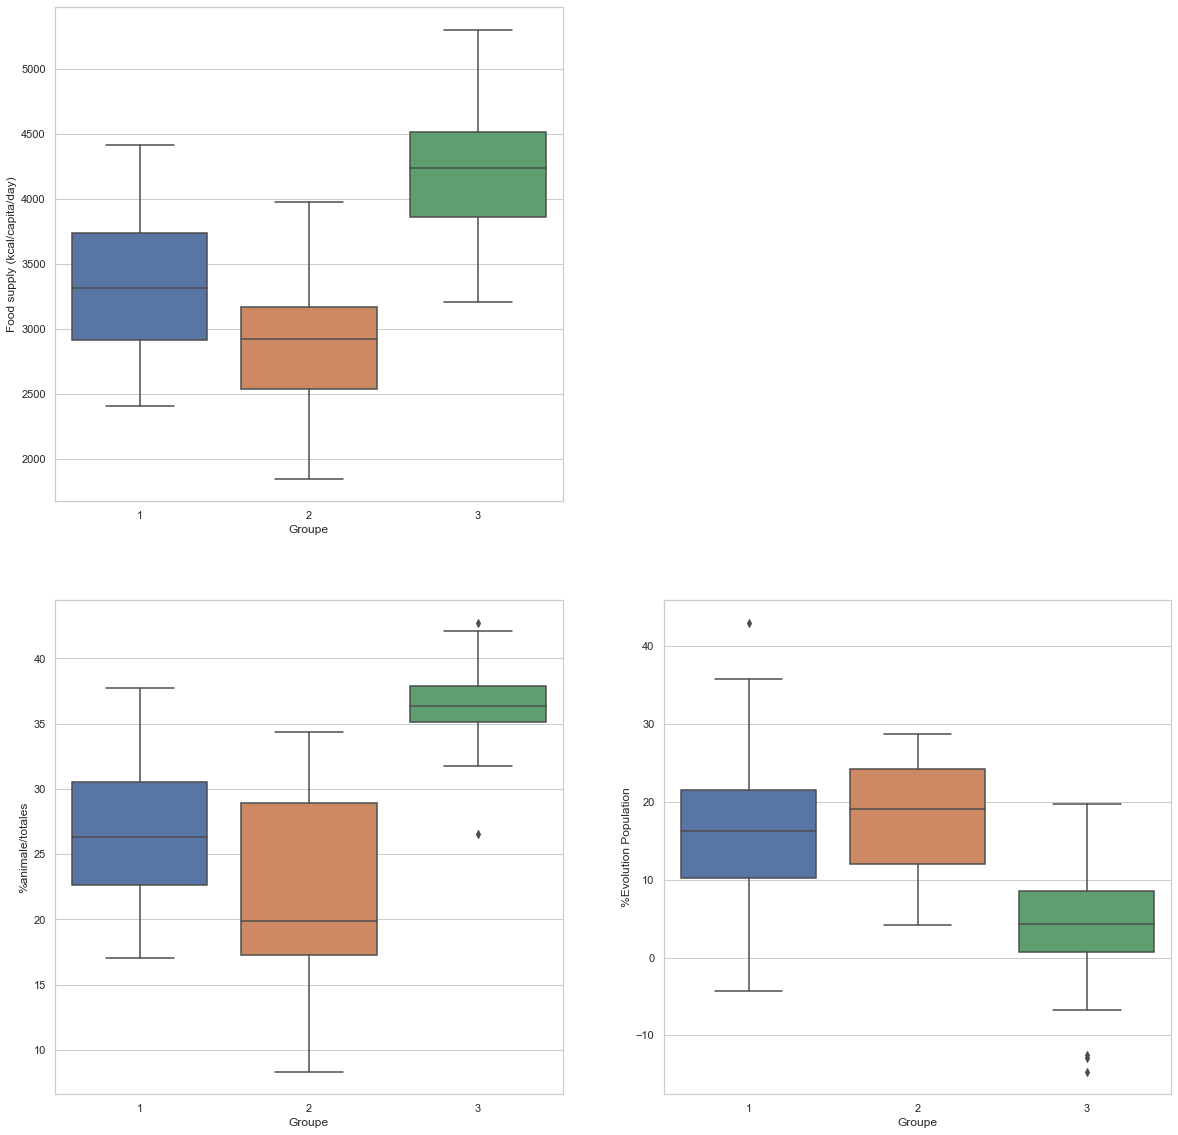

In [77]:
#Comparaison visuelle des groupes par Boxplot, en abscisse les numéros des groupes
plt.figure(figsize=(20, 20))
sns.set(style="whitegrid")

plt.subplot(221)
sns.boxplot(data=df_groupes_cah, x='Groupe', y='Food supply (kcal/capita/day)')


plt.subplot(223)
sns.boxplot(data=df_groupes_cah, x='Groupe', y='%animale/totales')

plt.subplot(224)
sns.boxplot(data=df_groupes_cah, x='Groupe', y='%Evolution Population')



plt.show(block=False)

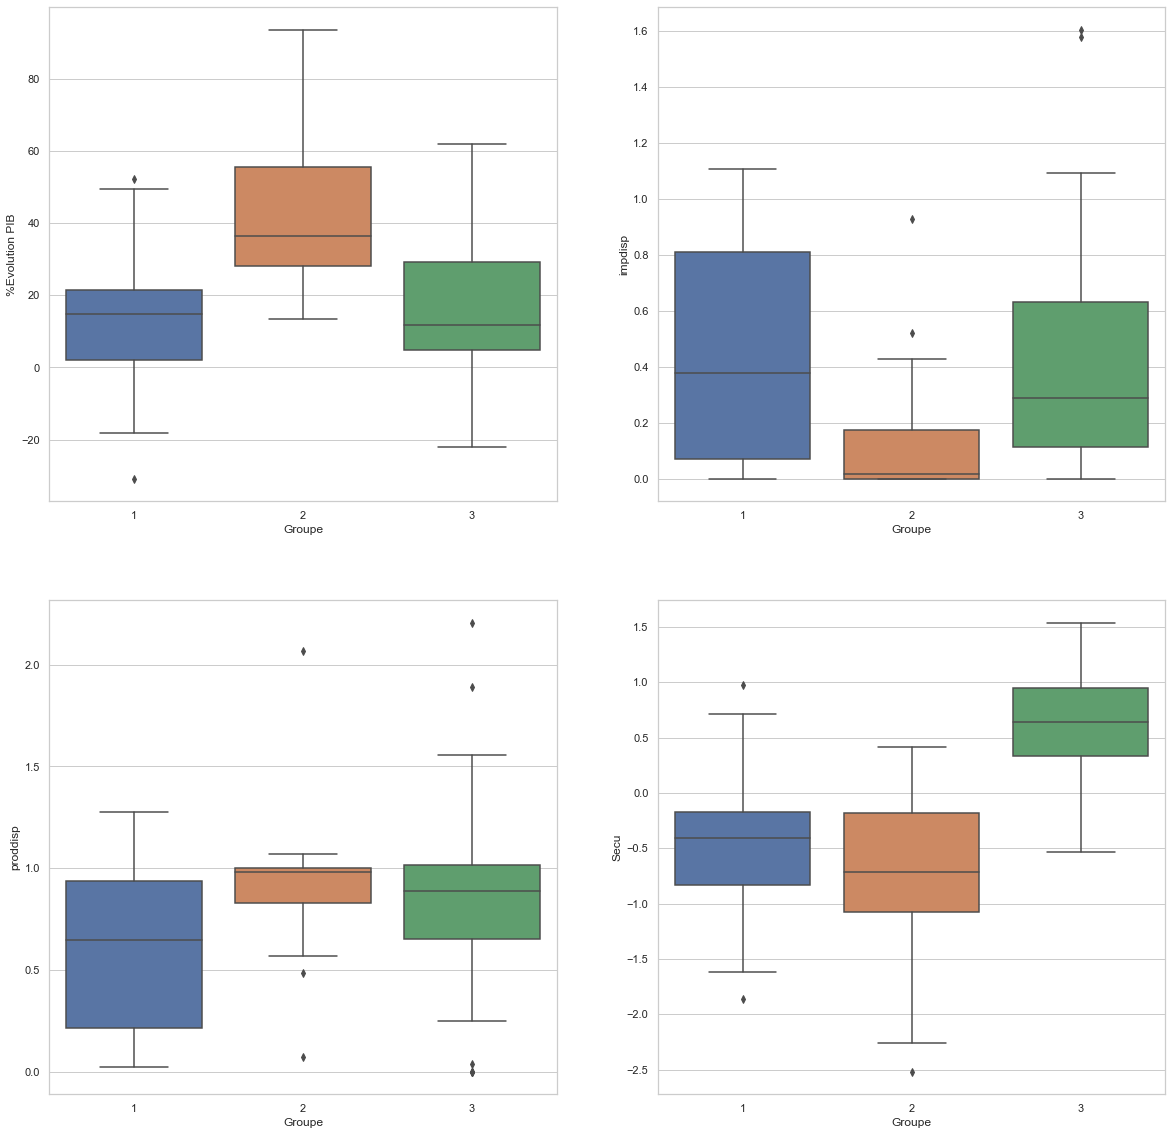

In [78]:
#Comparaison visuelle des groupes par Boxplot, en abscisse les numéros des groupes
plt.figure(figsize=(20, 20))
sns.set(style="whitegrid")

plt.subplot(221)
sns.boxplot(data=df_groupes_cah, x='Groupe', y='%Evolution PIB')

plt.subplot(222)
sns.boxplot(data=df_groupes_cah, x='Groupe', y='impdisp')

plt.subplot(223)
sns.boxplot(data=df_groupes_cah, x='Groupe', y='proddisp')


plt.subplot(224)
sns.boxplot(data=df_groupes_cah, x='Groupe', y='Secu')

plt.show(block=False)

#### Description des clusters

cluster 1  
-Importation poulet la plus elevé ( avec repartion tres étalé )  
-production poulet la moin elevé  
-croissance demographique assez elevée  
-coissance PIB moyenne  
-Sécurité plutot moyenne  

cluster 2  
-Importation poulet la plus faible  
-production poulet plutot la plus elevé en( moyenne)  
-croissance demographique et PIB la plus elevé  
-Sécurité la plus faible  


cluster 3  
-Importation poulet la plus faible  
-production poulet plutot elevé  
-croissance demographique la plus faible  
-coissance PIB plutot faible en moyenne  
-sécurité moyenne  

On retien le Groupe 1 parsque:
C'est le pus interessant coté evolution de pop et de PIB, donc c'est un marche en evolution en terme de taille et de capacité
Meme s'il presente un indice de secu bas ainsi que la plus faible disponibilié calorique en terme de moyenne,la distribution est assez etalé pour qu'on puisse des pays candidats

In [79]:
df_groupe1_cah

,Area,Food supply (kcal/capita/day),%animale/totales,%Evolution Population,%Evolution PIB,Secu,impdisp,proddisp,Groupe
1,Algeria,3872.0,20.96,17.76,7.83,-0.83,0.000000,1.003448,1
2,Angola,2656.0,22.98,29.58,-11.84,-0.32,0.850153,0.149847,1
5,Armenia,3997.0,35.92,1.49,21.47,-0.44,0.781818,0.218182,1
8,Azerbaijan,3733.0,26.54,11.33,10.12,-0.70,0.260000,0.746667,1
12,Benin,2903.0,17.02,24.28,15.43,-0.13,0.966942,0.123967,1
15,Botswana,2926.0,27.29,15.01,20.65,0.98,0.714286,0.285714,1
22,Congo,2405.0,32.45,23.51,-12.41,-0.34,0.946903,0.061947,1
30,Egypt,3574.0,19.87,19.09,16.42,-1.17,0.024374,0.976980,1
31,El Salvador,3170.0,26.08,4.50,16.52,-0.38,0.115152,0.890909,1
33,Eswatini,2818.0,23.26,7.60,18.73,-0.36,0.250000,0.750000,1


In [80]:
df_score_pib

NameError: name 'df_score_pib' is not defined

In [81]:

df_score_pop=df_groupe1_cah.sort_values(by='%Evolution Population', ascending=True,ignore_index=True)
df_score_pop['popscore'] = (df_groupe1_cah.sort_values(by='%Evolution Population', ascending=True,ignore_index=True)).index
df_score_pib=df_groupe1_cah.sort_values(by='%Evolution PIB', ascending=True,ignore_index=True)
df_score_pib['pib'] = (df_groupe1_cah.sort_values(by='%Evolution PIB', ascending=True,ignore_index=True)).index
df_score_secu=df_groupe1_cah.sort_values(by='Secu', ascending=True,ignore_index=True)
df_score_secu['secu'] = (df_groupe1_cah.sort_values(by='Secu', ascending=True,ignore_index=True)).index
df_tempscor= pd.merge(df_score_pop, df_score_pib, on='Area')

df_score=pd.merge(df_tempscor, df_score_secu, on='Area')
df_score_pop['popscore'] = df_score.index
df_score_final = df_score[['Area','popscore','pib','secu']]


df_score_final



,Area,popscore,pib,secu
0,Ukraine,0,6,0
1,Georgia,1,36,17
2,Republic of Moldova,2,34,19
3,North Macedonia,3,29,26
4,Armenia,4,27,16
5,El Salvador,5,23,20
6,Lesotho,6,19,27
7,Eswatini,7,24,21
8,Tunisia,8,15,8
9,Suriname,9,11,30


In [82]:
df_score_final['Score']=df_score_final['popscore']+df_score_final['pib']+df_score_final['secu']

C:\Users\Dell5520\AppData\Local\Temp/ipykernel_14384/2353773626.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_score_final['Score']=df_score_final['popscore']+df_score_final['pib']+df_score_final['secu']


In [83]:
df_score_final=df_score_final.sort_values(by='Score', ascending=False,ignore_index=True)
df_score_final

,Area,popscore,pib,secu,Score
0,Ghana,26,35,29,90
1,Timor-Leste,22,26,32,80
2,Benin,30,20,28,78
3,Botswana,17,25,36,78
4,United Arab Emirates,31,7,35,73
5,Oman,36,1,33,70
6,Namibia,19,17,34,70
7,Morocco,14,31,23,68
8,Kuwait,35,0,31,66
9,Guinea,27,32,7,66


In [84]:
df_groupe1_cah
df_score_final=pd.merge(df_score_final, df_groupe1_cah, on='Area')

df_score_final

,Area,popscore,pib,secu,Score,Food supply (kcal/capita/day),%animale/totales,%Evolution Population,%Evolution PIB,Secu,impdisp,proddisp,Groupe
0,Ghana,26,35,29,90,3238.0,19.13,20.84,49.36,-0.02,0.698630,0.301370,1
1,Timor-Leste,22,26,32,80,2428.0,17.85,16.76,21.03,0.24,0.916667,0.083333,1
2,Benin,30,20,28,78,2903.0,17.02,24.28,15.43,-0.13,0.966942,0.123967,1
3,Botswana,17,25,36,78,2926.0,27.29,15.01,20.65,0.98,0.714286,0.285714,1
4,United Arab Emirates,31,7,35,73,3596.0,30.75,26.39,-2.66,0.71,1.055385,0.069231,1
5,Oman,36,1,33,70,3533.0,32.59,43.04,-18.27,0.66,1.017699,0.061947,1
6,Namibia,19,17,34,70,2781.0,25.92,16.54,14.61,0.70,1.107143,0.392857,1
7,Morocco,14,31,23,68,3700.0,21.97,12.47,25.10,-0.34,0.008074,0.993080,1
8,Kuwait,35,0,31,66,4104.0,32.85,35.80,-30.87,0.11,0.740385,0.269231,1
9,Guinea,27,32,7,66,2990.0,17.09,21.55,32.32,-0.87,0.784314,0.215686,1


In [85]:
df_score_final=df_score_final.sort_values(by='Score', ascending=False,ignore_index=True)
df_score_final

,Area,popscore,pib,secu,Score,Food supply (kcal/capita/day),%animale/totales,%Evolution Population,%Evolution PIB,Secu,impdisp,proddisp,Groupe
0,Ghana,26,35,29,90,3238.0,19.13,20.84,49.36,-0.02,0.698630,0.301370,1
1,Timor-Leste,22,26,32,80,2428.0,17.85,16.76,21.03,0.24,0.916667,0.083333,1
2,Benin,30,20,28,78,2903.0,17.02,24.28,15.43,-0.13,0.966942,0.123967,1
3,Botswana,17,25,36,78,2926.0,27.29,15.01,20.65,0.98,0.714286,0.285714,1
4,United Arab Emirates,31,7,35,73,3596.0,30.75,26.39,-2.66,0.71,1.055385,0.069231,1
5,Oman,36,1,33,70,3533.0,32.59,43.04,-18.27,0.66,1.017699,0.061947,1
6,Namibia,19,17,34,70,2781.0,25.92,16.54,14.61,0.70,1.107143,0.392857,1
7,Morocco,14,31,23,68,3700.0,21.97,12.47,25.10,-0.34,0.008074,0.993080,1
8,Kuwait,35,0,31,66,4104.0,32.85,35.80,-30.87,0.11,0.740385,0.269231,1
9,Guinea,27,32,7,66,2990.0,17.09,21.55,32.32,-0.87,0.784314,0.215686,1


In [86]:
world.head()

NameError: name 'world' is not defined

In [87]:
import geopandas as gpd
import geoplot
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres')).drop(['pop_est', 'gdp_md_est'], axis=1)
world.rename(columns={'name': 'Area'}, inplace=True)
world

ModuleNotFoundError: No module named 'geopandas'

# Kmeans

In [ ]:
X = df.values

In [ ]:
std_scale = preprocessing.StandardScaler().fit(X)
X_scaled = std_scale.transform(X)

In [ ]:
silhouettes = [] 

#Boucle itérative de 2 à 10 (clusters) pour tester les possibilités
for k in range(2, 10): 
    #Création et ajustement d'un modèle pour chaque k
    cls = cluster.KMeans(n_clusters=k)  
    cls.fit(X_scaled)
    
    #Stockage des coefficients associés
    silh = metrics.silhouette_score(X_scaled, cls.labels_)
    silhouettes.append(silh)
    
#Visualisation des valeurs de coefficient de silhouette pour chaque nombre de cluster
plt.plot(range(2, 10), silhouettes, marker='o')
plt.show()

In [ ]:
cls4 = cluster.KMeans(n_clusters=4)
cls4.fit(X_scaled)

In [ ]:
clusters_kmeans4 = cls4.labels_

In [ ]:
pca = decomposition.PCA(svd_solver='full')
pca.fit(X_scaled)

In [ ]:
print(pca.explained_variance_ratio_.cumsum())

In [ ]:
pca = decomposition.PCA()
pca.fit(X_scaled)
scree = pca.explained_variance_ratio_*100

plt.bar(np.arange(len(scree))+1, scree)
plt.plot(np.arange(len(scree))+1, scree.cumsum(),c="red",marker='o')
    
plt.xlabel("rang de l'axe d'inertie")
plt.ylabel("pourcentage d'inertie")
plt.title("Eboulis des valeurs propres")
plt.show()

In [ ]:
#Coordonnées factorielles 
X_projected = pca.transform(X_scaled)
plt.figure(figsize=(20, 10))



plt.subplot(122)
plt.scatter(X_projected[:, 0], X_projected[:, 1], c=clusters_kmeans4)
plt.xlabel('F{} ({}%)'.format(1, round(100*pca.explained_variance_ratio_[0],1)))
plt.ylabel('F{} ({}%)'.format(2, round(100*pca.explained_variance_ratio_[1],1)))
plt.title("Projection en 5 clusters des {} individus sur le 1er plan factoriel".format(X_projected.shape[0]))


plt.show()

In [ ]:
centroids = cls4.cluster_centers_
pd.DataFrame(centroids, columns=df.columns)

In [ ]:
#Index trié des clusters
idk = np.argsort(cls4.labels_)

#Affichage des observations selon leurs clusters
df_cls4 = pd.DataFrame(df.index[idk], cls4.labels_[idk]).reset_index()
df_cls4 = df_cls4.rename(columns={'index':'cluster'})

In [ ]:
df_cls4 = pd.merge(df, df_cls4, on='Area')
df_cls4.head()

In [ ]:
cluster_mean_kmeans = df_cls4.groupby(['cluster']).mean()
cluster_mean_kmeans

In [ ]:
print(df_cls4[df_cls4['cluster'] == 0]['Area'].unique())
print(df_cls4[df_cls4['cluster'] == 1]['Area'].unique())
print(df_cls4[df_cls4['cluster'] == 2]['Area'].unique())
print(df_cls4[df_cls4['cluster'] == 3]['Area'].unique())

Le cluster 3 du K-means correspond a notre cluster 1 choisi en CAG (24/38 pays en commun)

## Test difference entre groupes

Pour vérifier que les groupes diffèrent réellement, on peut recourir aux tests statistiques. On choisit la variable : Food supply (kcal/capita/day. 

### Test de normalité

In [ ]:
from scipy.stats import shapiro

stat, p = shapiro(df['Food supply (kcal/capita/day)'])

print('Statistics=%.3f, p=%.3f' % (stat, p))

#Interprétation
alpha = 0.05
if p > alpha:
    print('On ne peut pas rejeter H0 pour des niveaux de test de 5%')
else:
    print('H0 est rejetée pour des niveaux de test de 5%')

-> H0 accepté :Le test de la variable 'Food supply (kcal/capita/day) exprimée en Kcal' répond positivement à une loi normale. 

In [ ]:
cluster_test1 = df_cls4[df_cls4['cluster'] == 1]['Food supply (kcal/capita/day)']
cluster_test2 = df_cls4[df_cls4['cluster'] == 0]['Food supply (kcal/capita/day)']

In [ ]:
df_cls4_0 = df_cls4[df_cls4['cluster'] == 1]
df_cls4_1 = df_cls4[df_cls4['cluster'] == 3]

In [ ]:
from scipy.stats import bartlett
comparaison_variances=bartlett(df_cls4_0['Food supply (kcal/capita/day)'], df_cls4_1['Food supply (kcal/capita/day)'])
print("Test de comparaison des variances: ratio nourriture/dispo poulets ")
print("statistc =", round(comparaison_variances[0], 2))
print("pvalue =", round(comparaison_variances[1], 2))

In [ ]:
df_cls4_0